# Formula One Project: Final Report

DUE: December 10th, 2024 (Tue)  
Name(s): Sean O'Connor, Connor Coles    
Class: CSCI 349 - Intro to Data Mining  
Semester: Fall 2024  
Instructor: Brian King  

## Assignment Description
This is your final report! Consider the scenario of you giving a report to a client or your supervisor on your study. Include good reporting techniques. Use good tables and other visualizations. Structure your notebook using proper headers for major sections. THIS NOTEBOOK SHOULD BE A COMPLETE STANDALONE NOTEBOOK FROM START TO FINISH! But, ONLY INCLUDE THE BEST OUTCOMES FROM YOUR PREVIOUS NOTEBOOKS!

Include the following sections:

1. **Introduction**
   - This should have mostly been done in your first notebook. Just copy over relevant cells from your first part of the project, and add any new information you have learned. Your aim is to motivate the reader with the importance and relevance of your project.

2. **Data**
   - Again, most of this was likely done in your first part of the project. So, feel free to copy the important cells over.
   - After your introduction, you should be introducing the original, raw data. Where was it collected? When? How? Explain the meaning of the variables. What does each observation represent? And be sure to explain the key target variable (assuming you are doing classification/regression).
   - PLEASE DO NOT SHOW PAGES AND PAGES OF YOUR DATA! Display only a few observations so that the reader can see what your raw, original data look like.

3. **Data Preparation**
   - While the previous section shows the raw data, this section is going to carefully explain the steps you followed to clean and preprocess the data in a form suitable for analysis, visualization, and modeling. You should be setting proper variable types, dealing with missing data, etc. Preprocessing steps should be explained with justification. Include any dimensionality reduction techniques you might have done. Summarize what you needed to do to clean it, and show some example observations from your final, cleaned data.

4. **EDA**
   - We expect good EDA to understand your data. Visualizations after preprocessing will do far more to convey your summary statistics than just numbers. Discuss the distributions, correlations with the target variable, etc.

5. **Modeling**
   - What modeling methods did you try? And, which method(s) did you ultimately determine were the best? What hyperparameters were selected? Justify the selection of parameters. (i.e., did you do a grid search? You cannot simply say, "XGBoost was the only one I evaluated, and I used default parameters." Boring, and unlikely to obtain the best results. You are expected to evaluate different models and different hyperparameters. It is very rare that default parameters are the best in machine learning.)

6. **Performance Results**
   - Once you've selected the best model, clearly convey the results of your model. I expect to see ROC curves, precision/recall curves, confusion matrices, tables with prediction performance by class, (or, if regression, use appropriate regression measures), etc.

7. **Discussion**
   - Reflect on your project. For example: discuss any challenges you had with cleaning and preparing the data. Did you find any surprises during your modeling? Compare and contrast the methods and hyperparameters you evaluated. And, it's often useful to discuss the features that you thought were the most predictive, and those that were least useful. (Search for feature importance scikit-learn for more info!) Any info that might be of interest to me related to your project goes here.

8. **Conclusions**
   - Write a short summary of your project goes here.

In [38]:
# Importing Libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import fastf1
import fastf1.plotting
from fastf1.ergast.structure import FastestLap

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
    
#print versions of libraries
print(f'Python version: {sys.version}')
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Matplotlib version: {plt.matplotlib.__version__}')
print(f'Seaborn version: {sns.__version__}')
print(f'FastF1 version: {fastf1.__version__}')
print(f'Scikit-learn version: {sys.modules["sklearn"].__version__}')
print(f'XGBoost version: {xgb.__version__}')
print(f'LightGBM version: {sys.modules["lightgbm"].__version__}')

Python version: 3.10.13 (main, Sep 11 2023, 08:24:56) [Clang 14.0.6 ]
Pandas version: 2.2.2
Numpy version: 1.23.5
Matplotlib version: 3.8.4
Seaborn version: 0.13.2
FastF1 version: 3.4.4
Scikit-learn version: 1.5.1
XGBoost version: 2.1.1
LightGBM version: 4.5.0


## Problem Statement
We are analyzing Formula One driver performance to understand and predict race outcomes based on various conditions. Specifically, we aim to:
1. Predict lap times based on weather and track conditions
2. Understand how different variables affect driver performance
3. Create models that can forecast race performance

This is primarily a regression problem, as we're predicting continuous values (lap times) based on multiple features.

In [18]:
# Set up FastF1 plotting and caching
cache_dir = '../data/cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

fastf1.Cache.enable_cache(cache_dir)
fastf1.plotting.setup_mpl(misc_mpl_mods=False, color_scheme=None)

In [19]:
# Define years, sessions, and events of interest
years = [2021, 2022, 2023, 2024]
sessions = ['Race']
events = ['Bahrain Grand Prix', 'Saudi Arabian Grand Prix', 'Dutch Grand Prix', 'Italian Grand Prix', 'Austrian Grand Prix', 'Hungarian Grand Prix', 'British Grand Prix', 'Belgian Grand Prix', 'United States Grand Prix', 'Mexico City Grand Prix', 'Sao Paulo Grand Prix']

## Why these events, sessions, and years?

These events were chosen because they are all currently scheduled for the 2024 season, as well as having occurred in previous years. 

Each event has a specific set of conditions that may affect driver performance:
- Bahrain: Hot and humid, with high track temperatures
- British: Cool and changeable, with frequent rain
- Belgian: Overcast and cool, with frequent weather changes
- United States: Very hot, with high track temperatures
- Mexico City: Cool and changeable, with frequent rain

As for years, we chose 2021 to 2024 because they are the most recent years for which data is available. In 2021, the regulations changed to allow for more overtaking, so the lap times became incomparable to that of previous years.

We chose to only use the 'Race' session because it is the most representative of a race condition, as opposed to qualifying, which can be very sporadic.

In [20]:
# Get data from FastF1 API

# Data containers
weather_data_list = []
lap_data_list = []

# Loop through years and sessions
for year in years:
    for event_name in events:   
        for session_name in sessions:
            try:
                print(f"Processing {year} {event_name} - {session_name}")
                
                # Load the session
                session = fastf1.get_session(year, event_name, session_name, backend='fastf1')
                session.load()
                
                # Process weather data
                weather_data = session.weather_data
                if weather_data is not None:
                    weather_df = pd.DataFrame(weather_data)
                    # Add context columns
                    weather_df['Year'] = year
                    weather_df['Event'] = event_name
                    weather_df['Session'] = session_name
                    weather_data_list.append(weather_df)

                # Process lap data
                lap_data = session.laps
                if lap_data is not None:
                    lap_df = pd.DataFrame(lap_data)
                    # Add context columns
                    lap_df['Year'] = year
                    lap_df['Event'] = event_name
                    lap_df['Session'] = session_name
                    # Ensure driver information is included
                    if 'Driver' not in lap_df.columns:
                        lap_df['Driver'] = lap_df['DriverNumber'].map(session.drivers)
                    # Add team information if available
                    if 'Team' not in lap_df.columns:
                        lap_df['Team'] = lap_df['Driver'].map(session.drivers_info['TeamName'])
                    lap_data_list.append(lap_df)
        
            except Exception as e:
                print(f"Error with {event_name} {session_name} ({year}): {e}")

# Combine data into DataFrames
if weather_data_list:
    weather_data_combined = pd.concat(weather_data_list, ignore_index=True)
    # Ensure consistent column ordering
    weather_cols = ['Time', 'Year', 'Event', 'Session', 
                   'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 
                   'TrackTemp', 'WindDirection', 'WindSpeed']
    weather_data_combined = weather_data_combined[weather_cols]
    
if lap_data_list:
    lap_data_combined = pd.concat(lap_data_list, ignore_index=True)
    # Ensure consistent column ordering
    lap_cols = ['Time', 'Year', 'Event', 'Session', 
                'Driver', 'Team', 'LapNumber', 'LapTime',
                'Sector1Time', 'Sector2Time', 'Sector3Time',
                'Compound', 'TyreLife', 'FreshTyre',
                'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']
    # Only include columns that exist
    existing_cols = [col for col in lap_cols if col in lap_data_combined.columns]
    lap_data_combined = lap_data_combined[existing_cols]
    
# Time conversion
# Function to convert timedelta to datetime
def convert_timedelta_to_datetime(df, base_date='2021-01-01'):
    if 'Time' in df.columns:
        # Create a base datetime and add the timedelta
        base = pd.Timestamp(base_date)
        if df['Time'].dtype == 'timedelta64[ns]':
            df['Time'] = base + df['Time']
    return df

# Apply conversion to both dataframes
weather_data_combined = convert_timedelta_to_datetime(weather_data_combined)
lap_data_combined = convert_timedelta_to_datetime(lap_data_combined)

# Remove missing values
weather_data_combined = weather_data_combined.dropna()
lap_data_combined = lap_data_combined.dropna()

# Create a new column for lap time in seconds
lap_data_combined['LapTime_seconds'] = lap_data_combined['LapTime'].dt.total_seconds()

# Merge the data
merged_data = pd.merge_asof(
    lap_data_combined.sort_values('Time'),
    weather_data_combined.sort_values('Time'),
    on='Time',
    by=['Event', 'Year'],  # Match within same event and year
    direction='nearest',
    tolerance=pd.Timedelta('1 min')  # Allow matching within 1 minute
)


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 2021 Bahrain Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '4', '11', '16', '3', '55', '22', '18', '7', '99', '31', '63', '5', '47', '10', '6', '14', '9']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 2021 Saudi Arabian Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '31', '3', '10', '16', '55', '99', '4', '18', '6', '14', '22', '7', '5', '11', '9', '63', '47']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 2021 Dutch Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '10', '16', '14', '55', '11', '31', '4', '3', '18', '5', '99', '88', '6', '63', '47', '22', '9']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data


Processing 2021 Italian Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '77', '16', '11', '55', '18', '14', '63', '31', '6', '5', '99', '88', '47', '9', '44', '33', '10', '22']
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2021 Austrian Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '77', '4', '44', '55', '11', '3', '16', '10', '14', '63', '22', '18', '99', '7', '6', '5', '47', '9', '31']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2021 Hungarian Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['31', '44', '55', '14', '10', '22', '6', '63', '33', '7', '3', '47', '99', '9', '4', '77', '11', '16', '18', '5']
core           INFO 	Loading data for British Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2021 British Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '16', '77', '4', '3', '55', '14', '18', '31', '22', '10', '63', '99', '6', '7', '11', '9', '47', '5', '33']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2021 Belgian Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '63', '44', '3', '5', '10', '31', '16', '6', '55', '14', '77', '99', '4', '22', '47', '9', '7', '11', '18']
core           INFO 	Loading data for United States Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2021 United States Grand Prix - Race


core        WARNING 	Driver  7: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '11', '16', '3', '77', '55', '4', '22', '5', '99', '18', '7', '63', '6', '47', '9', '14', '31', '10']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Process

Processing 2021 Mexico City Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '11', '10', '16', '55', '5', '7', '14', '4', '99', '3', '31', '18', '77', '63', '6', '9', '47', '22']
events      WARNING 	Correcting user input 'Sao Paulo Grand Prix' to 'São Paulo Grand Prix'
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           IN

Processing 2021 Sao Paulo Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '11', '16', '55', '10', '31', '14', '4', '5', '7', '63', '99', '22', '6', '9', '47', '3', '18']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2022 Bahrain Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '44', '63', '20', '77', '31', '22', '14', '24', '47', '18', '23', '3', '4', '6', '27', '11', '1', '10']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2022 Saudi Arabian Grand Prix - Race


core        WARNING 	No lap data for driver 22
core        WARNING 	No lap data for driver 47
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 22)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 47)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '11', '63', '31', '4', '10', '20', '44', '24', '27', '18', '23', '77', '14', '3', '6', '22', '47']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_coun

Processing 2022 Dutch Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '63', '16', '44', '11', '14', '4', '55', '31', '18', '10', '23', '47', '5', '20', '24', '3', '6', '77', '22']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2022 Italian Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '55', '44', '11', '4', '10', '45', '24', '31', '47', '77', '22', '6', '20', '3', '18', '14', '5']
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2022 Austrian Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '44', '63', '31', '47', '4', '20', '3', '14', '77', '23', '18', '24', '10', '22', '5', '55', '6', '11']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2022 Hungarian Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '55', '11', '16', '4', '14', '31', '5', '18', '10', '24', '47', '3', '20', '23', '6', '22', '77']
core           INFO 	Loading data for British Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2022 British Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '11', '44', '16', '14', '4', '1', '47', '5', '20', '18', '6', '3', '22', '31', '10', '77', '63', '24', '23']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 2022 Belgian Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '63', '14', '16', '31', '5', '10', '23', '18', '4', '22', '24', '3', '20', '47', '6', '77', '44']
events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'
core           INFO 	Loading data for United States Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req         

Processing 2022 United States Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '16', '11', '63', '4', '14', '5', '20', '22', '31', '24', '23', '10', '47', '3', '6', '18', '77', '55']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 2022 Mexico City Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '11', '63', '55', '16', '3', '31', '4', '77', '10', '23', '24', '5', '18', '47', '20', '6', '14', '22']
events      WARNING 	Correcting user input 'Sao Paulo Grand Prix' to 'São Paulo Grand Prix'
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Usi

Processing 2022 Sao Paulo Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '44', '55', '16', '14', '1', '11', '31', '77', '18', '5', '24', '47', '10', '23', '6', '22', '4', '20', '3']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 2023 Bahrain Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 2023 Saudi Arabian Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '1', '14', '63', '44', '55', '16', '31', '10', '20', '22', '27', '24', '21', '81', '2', '4', '77', '23', '18']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 2023 Dutch Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '10', '11', '55', '44', '4', '23', '81', '31', '18', '27', '40', '77', '22', '20', '63', '24', '16', '2']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 2023 Italian Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '44', '23', '4', '14', '77', '40', '81', '2', '24', '10', '18', '27', '20', '31', '22']
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 2023 Austrian Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '4', '14', '55', '63', '44', '18', '10', '23', '24', '2', '31', '77', '81', '21', '20', '22', '27']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_d

Processing 2023 Hungarian Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '11', '44', '81', '63', '16', '55', '14', '18', '23', '77', '3', '27', '22', '24', '20', '2', '31', '10']
core           INFO 	Loading data for British Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2023 British Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '81', '63', '11', '14', '23', '16', '55', '2', '77', '27', '18', '24', '22', '21', '10', '20', '31']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2023 Belgian Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '44', '14', '63', '4', '31', '18', '22', '10', '77', '24', '23', '20', '3', '2', '27', '55', '81']
events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'
core           INFO 	Loading data for United States Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
cor

Processing 2023 United States Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '55', '11', '63', '10', '18', '22', '23', '2', '27', '77', '24', '20', '3', '14', '81', '31', '44', '16']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2023 Mexico City Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '16', '55', '4', '63', '3', '81', '23', '31', '10', '22', '27', '24', '77', '2', '18', '14', '20', '11']
events      WARNING 	Correcting user input 'Sao Paulo Grand Prix' to 'São Paulo Grand Prix'
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           

Processing 2023 Sao Paulo Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '14', '11', '18', '55', '10', '44', '22', '31', '2', '27', '3', '81', '63', '77', '24', '20', '23', '16']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2024 Bahrain Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2024 Saudi Arabian Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '81', '14', '63', '38', '4', '44', '27', '23', '20', '31', '2', '22', '3', '77', '24', '18', '10']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...


Processing 2024 Dutch Grand Prix - Race


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

Processing 2024 Italian Grand Prix - Race


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

Processing 2024 Austrian Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '81', '55', '44', '1', '27', '11', '20', '3', '10', '16', '31', '18', '22', '23', '77', '24', '14', '2', '4']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...


Processing 2024 Hungarian Grand Prix - Race


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

Processing 2024 British Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '1', '4', '81', '55', '27', '18', '14', '23', '22', '2', '20', '3', '16', '77', '31', '11', '24', '63', '10']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...


Processing 2024 Belgian Grand Prix - Race


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

Processing 2024 United States Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '1', '4', '81', '63', '11', '27', '30', '43', '20', '10', '14', '22', '18', '23', '77', '31', '24', '44']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 2024 Mexico City Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '4', '16', '44', '63', '1', '20', '81', '27', '10', '18', '43', '31', '77', '24', '30', '11', '14', '23', '22']
events      WARNING 	Correcting user input 'Sao Paulo Grand Prix' to 'São Paulo Grand Prix'
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	

Processing 2024 Sao Paulo Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 23
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 23)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '31', '10', '63', '16', '4', '22', '81', '30', '44', '11', '50', '77', '14', '24', '55', '43', '23', '18', '27']


## Data Description
Our data comes from the FastF1 API, which provides detailed Formula One racing data. Each observation represents a single lap during a race or qualifying session, including:

Key Variables:
- **Time**: Timestamp of the lap
- **Driver**: Driver identifier
- **LapTime**: Time taken to complete the lap
- **Weather Conditions**:
  - TrackTemp: Track temperature in Celsius
  - AirTemp: Air temperature in Celsius
  - Humidity: Percentage
  - Rainfall: Boolean indicating presence of rain
- **Performance Metrics**:
  - Sector times (1,2,3)
  - Speed measurements at various points
  - Compound: Tire compound used
  - TyreLife: Age of tires in laps

Each lap is represented as a fixed-length vector containing these attributes, making it suitable for machine learning algorithms.

In [21]:
# Display a sample of the raw data
lap_data_combined.head()

,Time,Year,Event,Session,Driver,Team,LapNumber,LapTime,Sector1Time,Sector2Time,Sector3Time,Compound,TyreLife,FreshTyre,SpeedI1,SpeedI2,SpeedFL,SpeedST,LapTime_seconds
1,2021-01-01 00:41:37.134,2021,Bahrain Grand Prix,Race,GAS,AlphaTauri,2.0,0 days 00:02:22.263000,0 days 00:00:45.220000,0 days 00:01:00.086000,0 days 00:00:36.957000,MEDIUM,5.0,False,120.0,134.0,182.0,236.0,142.263
4,2021-01-01 00:48:28.044,2021,Bahrain Grand Prix,Race,GAS,AlphaTauri,5.0,0 days 00:02:11.534000,0 days 00:01:05.748000,0 days 00:00:41.956000,0 days 00:00:23.830000,HARD,1.0,True,231.0,251.0,275.0,213.0,131.534
5,2021-01-01 00:50:04.721,2021,Bahrain Grand Prix,Race,GAS,AlphaTauri,6.0,0 days 00:01:36.677000,0 days 00:00:30.990000,0 days 00:00:41.802000,0 days 00:00:23.885000,HARD,2.0,True,233.0,254.0,275.0,280.0,96.677
6,2021-01-01 00:51:41.675,2021,Bahrain Grand Prix,Race,GAS,AlphaTauri,7.0,0 days 00:01:36.954000,0 days 00:00:31.176000,0 days 00:00:41.678000,0 days 00:00:24.100000,HARD,3.0,True,232.0,252.0,274.0,282.0,96.954
8,2021-01-01 00:54:56.129,2021,Bahrain Grand Prix,Race,GAS,AlphaTauri,9.0,0 days 00:01:37.030000,0 days 00:00:31.256000,0 days 00:00:41.911000,0 days 00:00:23.863000,HARD,5.0,True,234.0,248.0,276.0,286.0,97.030


## Data Preprocessing Steps
1. Time Conversion:
   - Converting lap times from timedelta to seconds
   - Standardizing timestamps for weather correlation

2. Missing Value Handling:
   - Removing incomplete laps
   - Handling missing weather data

3. Feature Engineering:
   - Creating derived features from raw data
   - Normalizing numerical values

4. Data Integration:
   - Merging weather and lap data
   - Ensuring temporal alignment of measurements

In [22]:
# Time conversion
# Function to convert timedelta to datetime
def convert_timedelta_to_datetime(df, base_date='2021-01-01'):
    if 'Time' in df.columns:
        # Create a base datetime and add the timedelta
        base = pd.Timestamp(base_date)
        if df['Time'].dtype == 'timedelta64[ns]':
            df['Time'] = base + df['Time']
    return df

# Apply conversion to both dataframes
weather_data_combined = convert_timedelta_to_datetime(weather_data_combined)
lap_data_combined = convert_timedelta_to_datetime(lap_data_combined)

In [23]:
# Remove missing values
weather_data_combined = weather_data_combined.dropna()
lap_data_combined = lap_data_combined.dropna()

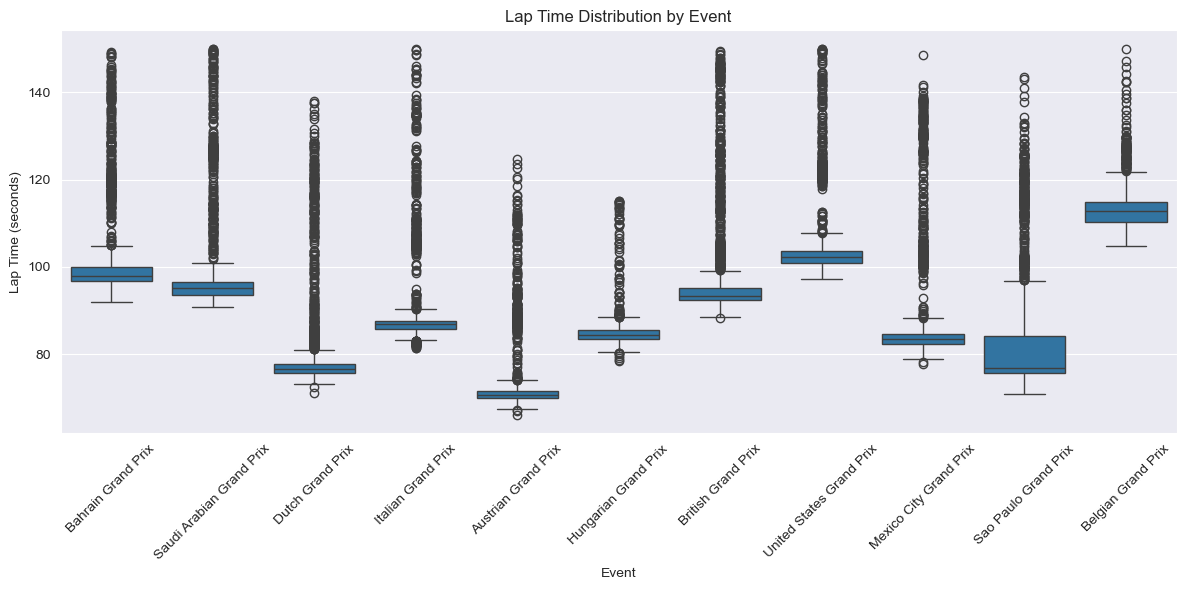

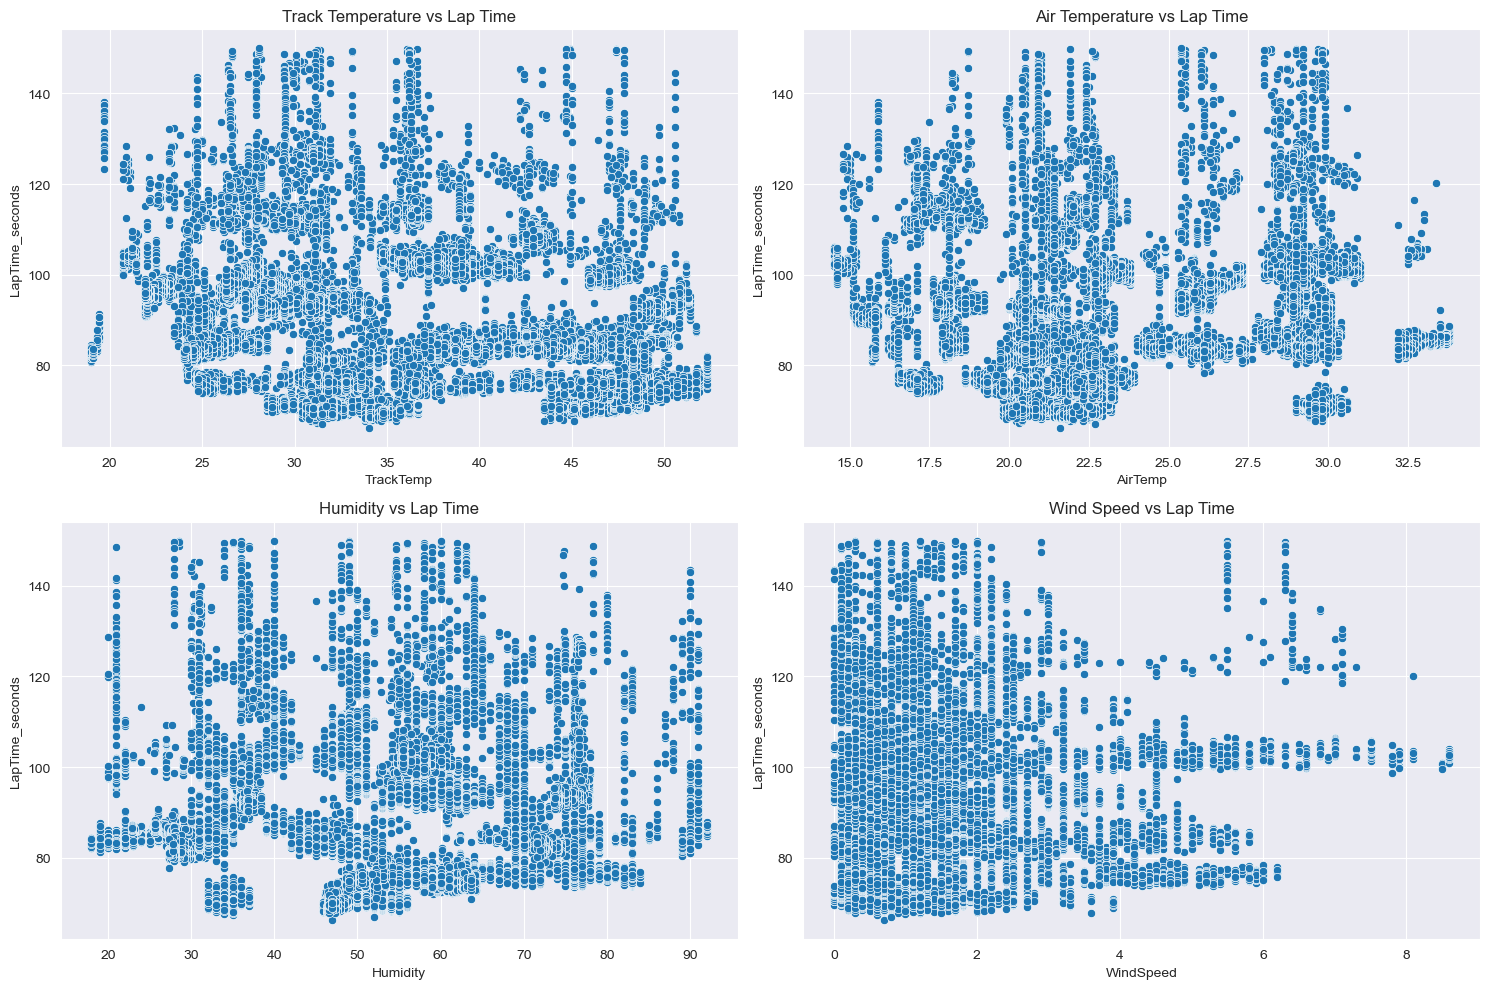

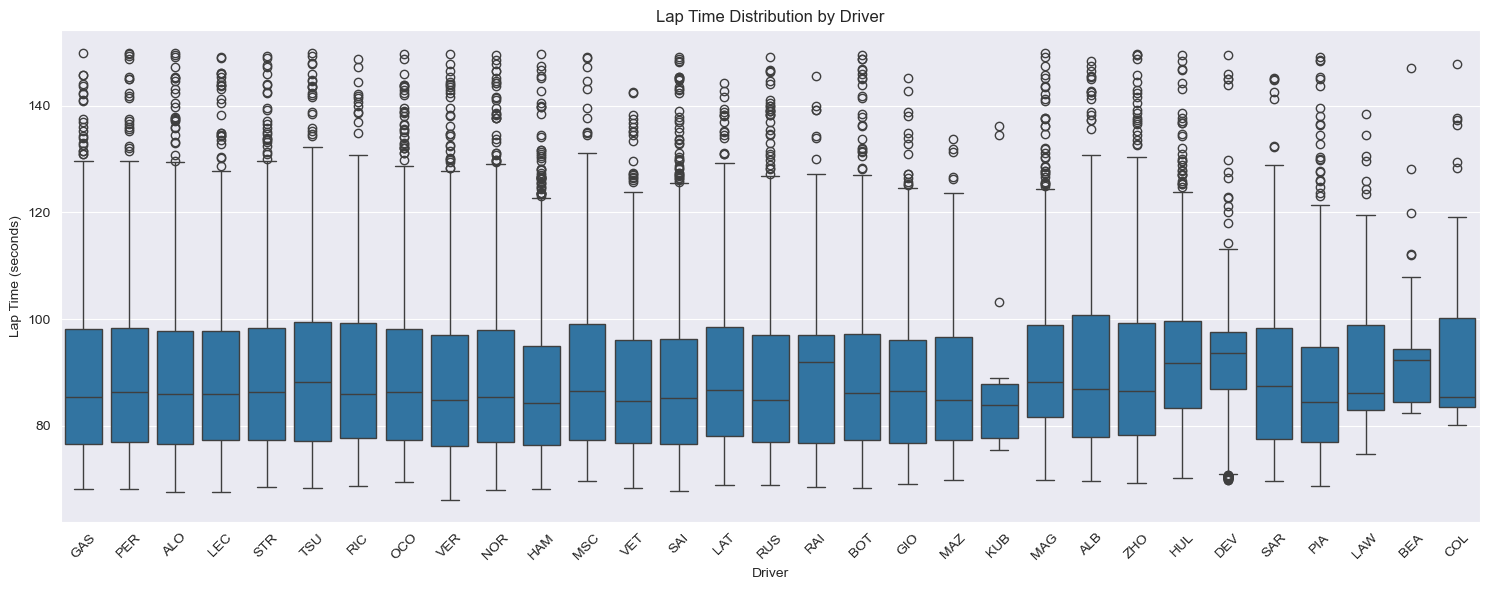

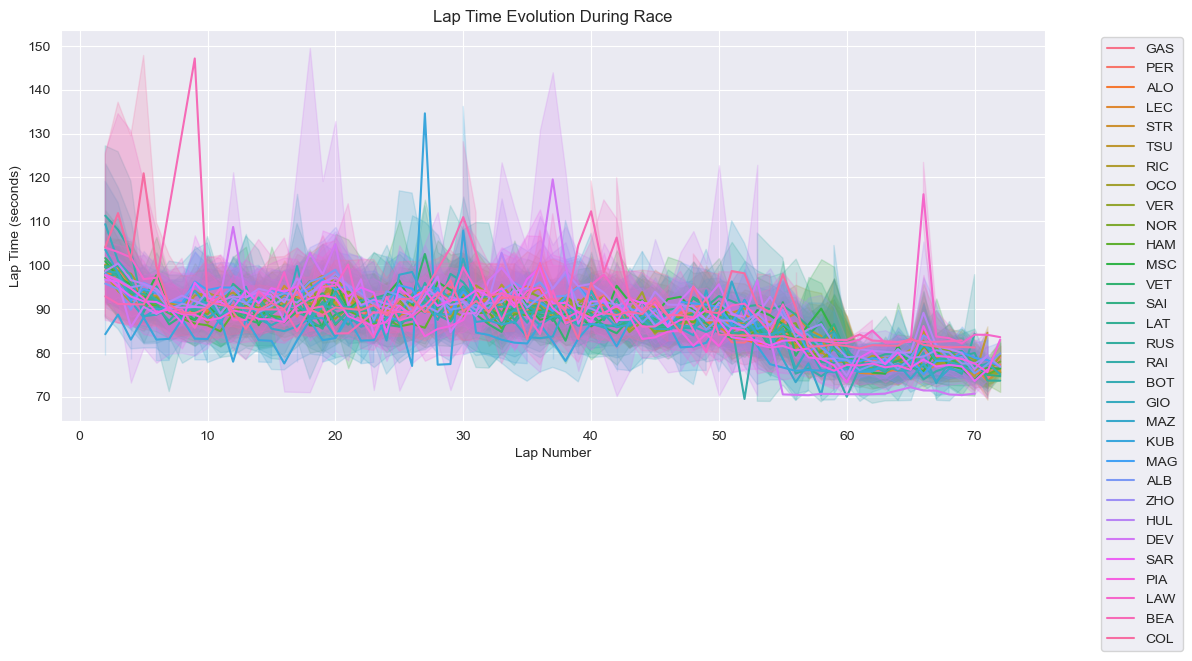

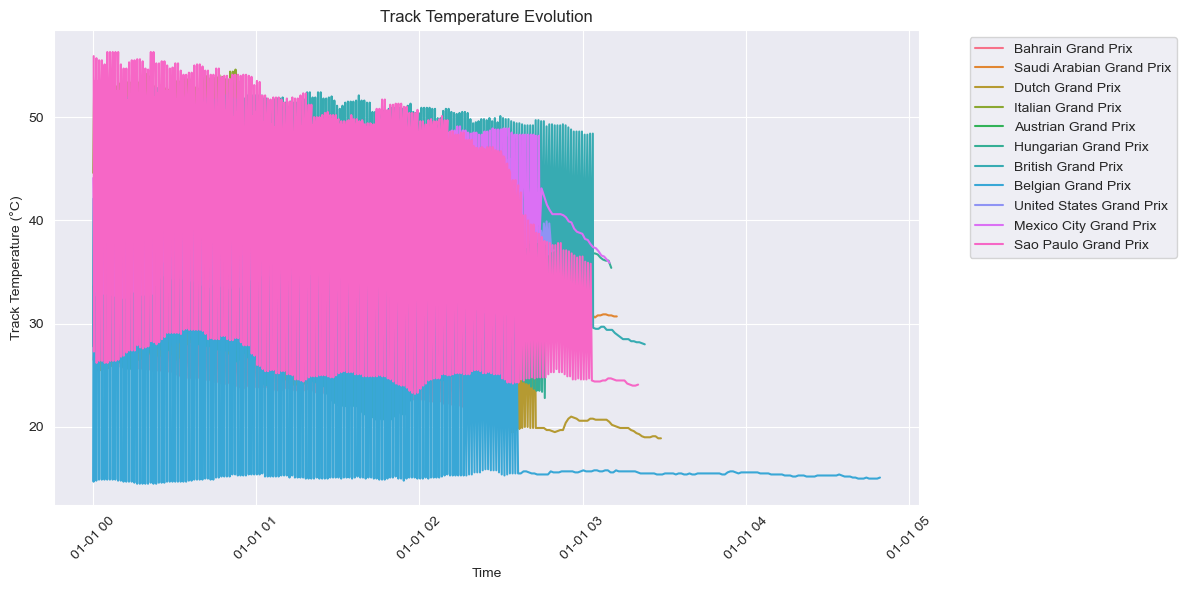

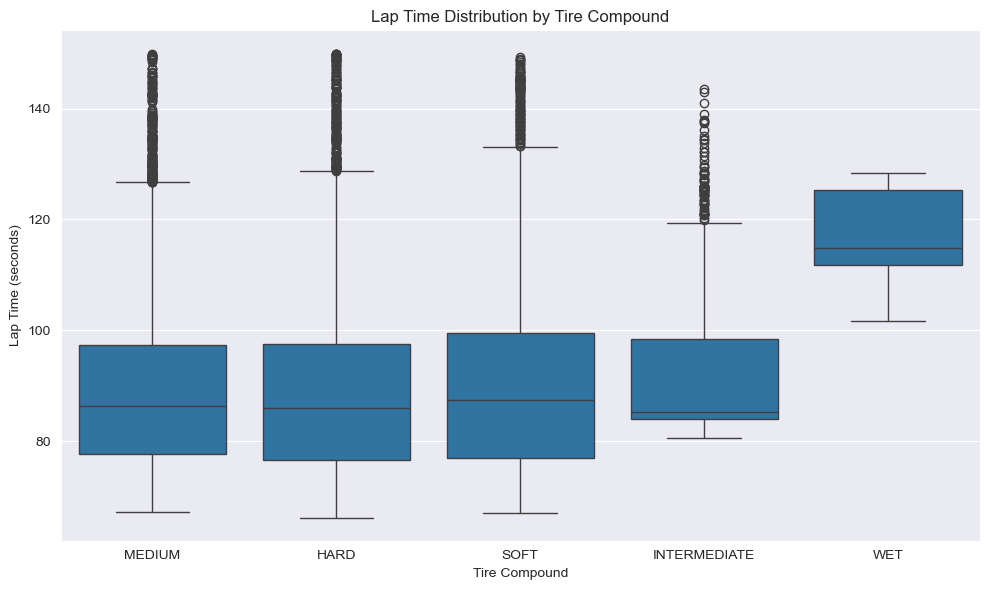

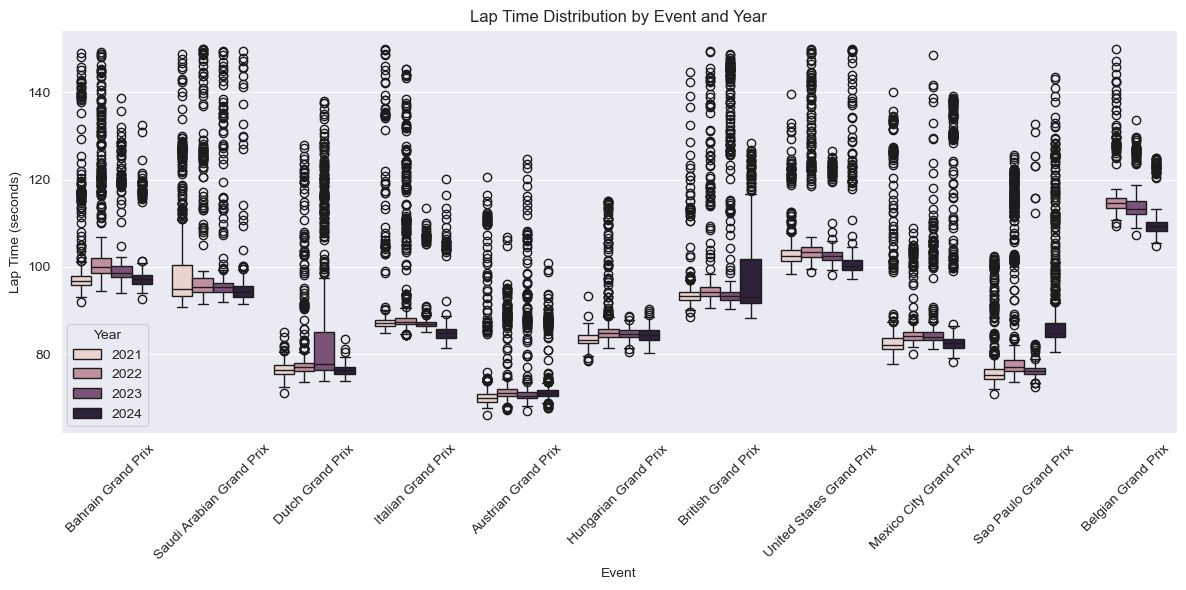

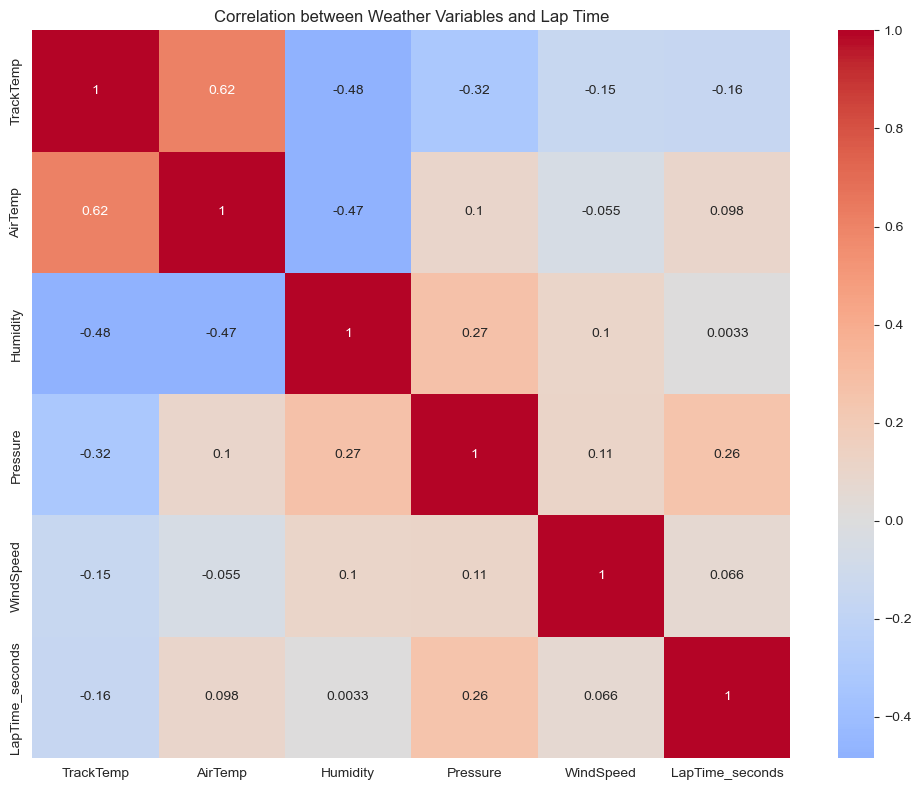

In [24]:
# Set up the plotting style
plt.rcParams['figure.figsize'] = [12, 6]

# 1. Lap Time Distribution by Event
plt.figure(figsize=(12, 6))
sns.boxplot(data=lap_data_combined, x='Event', y='LapTime_seconds')
plt.xticks(rotation=45)
plt.title('Lap Time Distribution by Event')
plt.xlabel('Event')
plt.ylabel('Lap Time (seconds)')
plt.tight_layout()
plt.show()

# 2. Weather Conditions Impact
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.scatterplot(data=merged_data, x='TrackTemp', y='LapTime_seconds', ax=axes[0,0])
axes[0,0].set_title('Track Temperature vs Lap Time')

sns.scatterplot(data=merged_data, x='AirTemp', y='LapTime_seconds', ax=axes[0,1])
axes[0,1].set_title('Air Temperature vs Lap Time')

sns.scatterplot(data=merged_data, x='Humidity', y='LapTime_seconds', ax=axes[1,0])
axes[1,0].set_title('Humidity vs Lap Time')

sns.scatterplot(data=merged_data, x='WindSpeed', y='LapTime_seconds', ax=axes[1,1])
axes[1,1].set_title('Wind Speed vs Lap Time')
plt.tight_layout()
plt.show()

# 3. Driver Performance Comparison
plt.figure(figsize=(15, 6))
sns.boxplot(data=lap_data_combined, x='Driver', y='LapTime_seconds')
plt.xticks(rotation=45)
plt.title('Lap Time Distribution by Driver')
plt.xlabel('Driver')
plt.ylabel('Lap Time (seconds)')
plt.tight_layout()
plt.show()

# 4. Lap Time Evolution Over Race
plt.figure(figsize=(12, 6))
sns.lineplot(data=lap_data_combined, x='LapNumber', y='LapTime_seconds', hue='Driver')
plt.title('Lap Time Evolution During Race')
plt.xlabel('Lap Number')
plt.ylabel('Lap Time (seconds)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 5. Track Temperature Changes
plt.figure(figsize=(12, 6))
sns.lineplot(data=weather_data_combined, x='Time', y='TrackTemp', hue='Event')
plt.title('Track Temperature Evolution')
plt.xlabel('Time')
plt.ylabel('Track Temperature (°C)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 6. Tire Compound Impact
plt.figure(figsize=(10, 6))
sns.boxplot(data=lap_data_combined, x='Compound', y='LapTime_seconds')
plt.title('Lap Time Distribution by Tire Compound')
plt.xlabel('Tire Compound')
plt.ylabel('Lap Time (seconds)')
plt.tight_layout()
plt.show()

# 7. Year-over-Year Comparison
plt.figure(figsize=(12, 6))
sns.boxplot(data=lap_data_combined, x='Event', y='LapTime_seconds', hue='Year')
plt.xticks(rotation=45)
plt.title('Lap Time Distribution by Event and Year')
plt.xlabel('Event')
plt.ylabel('Lap Time (seconds)')
plt.tight_layout()
plt.show()

# 8. Weather Correlation Heatmap
weather_vars = ['TrackTemp', 'AirTemp', 'Humidity', 'Pressure', 'WindSpeed', 'LapTime_seconds']
correlation = merged_data[weather_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Weather Variables and Lap Time')
plt.tight_layout()
plt.show()

## Modeling Approach
This is primarily a regression problem as we're predicting continuous lap times. We plan to use:

1. Basic Models:
   - Gradient Boosting (Basic Model)
   - Random Forest Regression
   - XGBoost
   - LightGBM

2. Advanced Techniques:
   - Cross-validation for model evaluation
   - Hyperparameter tuning



## Reasoning Behind Model Selection
In our project, we chose to use Random Forest Regression, Gradient Boosting, XGBoost, and LightGBM for predicting lap times in Formula One races. The selection of these models is inspired by the comparative study presented in the paper "A Comparison of Regression Models for Prediction of Graduate Admissions" and "A Comparative Analysis of Gradient Boosting Algorithms".  Here is a brief description of why we chose each model:


### Random Forest Regression
Random Forest is an ensemble learning technique that builds multiple decision trees and combines their predictions to improve accuracy and reduce overfitting. The paper found that Random Forest Regression is robust to outliers and noise, making it suitable for regression tasks with complex relationships. Random Forest can handle high-dimensional data and capture non-linear patterns effectively. It is known for its simplicity, scalability, and resistance to overfitting. We include Random Forest Regression in our analysis to leverage its robustness and generalization capabilities.

### Gradient Boosting
Gradient Boosting is another ensemble learning technique that builds multiple decision trees sequentially, with each tree correcting the errors of its predecessor. The paper found that Gradient Boosting outperformed both Linear Regression and Random Forest Regression, with the lowest MSE and the highest R-squared score. This model is known for its high predictive power and ability to capture complex patterns in the data. We include Gradient Boosting in our analysis to leverage its superior performance in regression tasks.

### XGBoost
XGBoost is an optimized implementation of Gradient Boosting that offers additional regularization techniques to prevent overfitting. The paper found it introduces regularization parameters to control the complexity of the trees, which enhances generalization. XGBoost employs several optimization techniques, including a sparsity-aware algorithm for efficient split finding, pre-sorted data structures for faster training, and the ability to handle missing data effectively. XGBoost is known for its speed and scalability, making it an attractive choice for large datasets. We include XGBoost in our analysis to evaluate its performance and compare it against Gradient Boosting.

### LightGBM
LightGBM is another gradient boosting framework that uses a histogram-based algorithm to achieve faster training speeds and lower memory usage.The paper found that it uses unique techniques such as Gradient-based One-Side Sampling (GOSS) and Exclusive Feature Bundling (EFB) to improve efficiency. GOSS focuses on instances with higher gradients for training, while EFB bundles sparse features.LightGBM prefers a leaf-wise tree growth approach, which often results in deeper trees and better accuracy for large datasets. It is optimized for computational efficiency, supporting both CPU and GPU-based training. LightGBM is known for its efficiency in handling large datasets and high-dimensional features. We include LightGBM in our analysis to evaluate its performance and compare it against XGBoost.

Sources: https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=  
         https://link.springer.com/content/pdf/10.1007/s10462-020-09896-5.pdf?error=cookies_not_supported&code=efdc961b-c226-462a-806a-36e221a60632
         


In [40]:
def engineer_features(df):
    """
    Engineer features for F1 lap time prediction with enhanced track-specific optimizations.
    
    Parameters:
        df (pandas.DataFrame): Input dataframe containing raw F1 session data
    Returns:
        pandas.DataFrame: DataFrame with engineered features
    """
    # Basic weather and track condition features
    df['GripCondition'] = df.apply(lambda x: 
        x['TrackTemp'] * (1 - x['Humidity']/150) * (1 - abs(x['WindSpeed'])/50) if 'British' in x['Event']
        else x['TrackTemp'] * (1 - x['Humidity']/100), axis=1)
    
    df['TempDelta'] = df['TrackTemp'] - df['AirTemp']
    
    # Enhanced tire degradation with weather impact
    df['TyreDeg'] = df.apply(lambda x: 
        np.exp(-0.025 * x['TyreLife']) * (1 - x['Humidity']/200) if 'British' in x['Event']
        else np.exp(-0.025 * x['TyreLife']) if 'Belgian' in x['Event']
        else np.exp(-0.015 * x['TyreLife']), axis=1)
    
    # Track evolution with enhanced weather adjustment
    df['TrackEvolution'] = df.apply(lambda x: 
        (1 - np.exp(-0.15 * x['LapNumber'])) * (1 - x['Humidity']/250) * (1 - abs(x['WindSpeed'])/40) if 'British' in x['Event']
        else (1 - np.exp(-0.15 * x['LapNumber'])) if 'United States' in x['Event']
        else 1 - np.exp(-0.1 * x['LapNumber']), axis=1)
    
    # Temperature interactions
    df['TempInteraction'] = df['TrackTemp'] * df['AirTemp']
    df['TempInteractionSquared'] = df['TempInteraction'] ** 2
    
    # Enhanced weather complexity
    df['WeatherComplexity'] = df.apply(lambda x:
        (x['WindSpeed'] * 0.4 + abs(x['TempDelta']) * 0.4 + x['Humidity'] * 0.2) / 100.0 if 'British' in x['Event']
        else (x['WindSpeed'] * 0.3 + abs(x['TempDelta']) * 0.4 + x['Humidity'] * 0.3) / 100.0 if 'Belgian' in x['Event']
        else (x['WindSpeed'] * 0.2 + abs(x['TempDelta']) * 0.5 + x['Humidity'] * 0.3) / 100.0,
        axis=1)
    
    # Track-specific features
    df['DesertEffect'] = np.where(
        df['Event'].str.contains('Bahrain'),
        df['WindSpeed'] * df['Humidity'] * df['TempInteraction'] / 10000,
        0
    )
    
    # Enhanced wet weather effect
    df['WetWeatherEffect'] = df.apply(lambda x:
        (x['Humidity'] * x['WindSpeed'] * abs(x['TempDelta'])) / 800 if 'British' in x['Event']
        else (x['Humidity'] * x['WindSpeed'] * abs(x['TempDelta'])) / 1000 if 'Belgian' in x['Event']
        else 0, axis=1)
    
    df['AltitudeEffect'] = np.where(
        df['Event'].str.contains('Mexico City'),
        df['AirTemp'] * (1 - df['Humidity']/200) * df['WindSpeed'] / 10,
        0
    )
    
    df['WeatherStability'] = df.apply(lambda x:
        1 - (abs(x['WindSpeed']) + abs(x['TempDelta']) + x['Humidity'])/300 if 'British' in x['Event']
        else 1, axis=1)
    
    df['TrackCondition'] = df.apply(lambda x:
        (x['TrackTemp'] * x['WeatherStability'] * (1 - x['WetWeatherEffect'])) if 'British' in x['Event']
        else x['TrackTemp'], axis=1)
    
    # Rolling averages for weather stability (3-lap window)
    df['WindSpeed_Rolling'] = df.groupby('Event')['WindSpeed'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    df['Humidity_Rolling'] = df.groupby('Event')['Humidity'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    df['TrackTemp_Rolling'] = df.groupby('Event')['TrackTemp'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    
    # Weather change indicators
    df['WeatherChangeRate'] = df.apply(lambda x:
        abs(x['WindSpeed'] - x['WindSpeed_Rolling']) + 
        abs(x['Humidity'] - x['Humidity_Rolling']) + 
        abs(x['TrackTemp'] - x['TrackTemp_Rolling']) if 'British' in x['Event']
        else 0, axis=1)
    
    return df

In [44]:
def prepare_modeling_data(df):
    """
    Prepare data for modeling with optimized track-specific configurations.
    """
    data = engineer_features(df)
    track_results = {}
    
    base_features = [
        'TrackTemp', 'AirTemp', 'Humidity', 'WindSpeed',
        'TyreLife', 'TyreDeg', 'TempDelta', 'GripCondition',
        'TrackEvolution', 'TempInteraction', 'TempInteractionSquared',
        'WeatherComplexity', 'DesertEffect', 'WetWeatherEffect', 'AltitudeEffect',
        'WeatherStability', 'TrackCondition', 'WeatherChangeRate',
        'WindSpeed_Rolling', 'Humidity_Rolling', 'TrackTemp_Rolling'
    ]
    
    track_configs = {
        'default': {
            'n_estimators': 300,
            'max_depth': 7,
            'learning_rate': 0.005,
            'min_child_samples': 25,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'reg_alpha': 0.2,
            'reg_lambda': 1.5,
            'num_leaves': 35,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5
        },
        # 'British': {
        #     'n_estimators': 500,
        #     'max_depth': 8,
        #     'learning_rate': 0.002,
        #     'min_child_samples': 30,
        #     'subsample': 0.75,
        #     'colsample_bytree': 0.75,
        #     'reg_alpha': 0.3,
        #     'reg_lambda': 2.0,
        #     'num_leaves': 30,
        #     'feature_fraction': 0.7,
        #     'bagging_fraction': 0.7,
        #     'bagging_freq': 7
        # },
        # 'Bahrain': {
        #     'n_estimators': 400,
        #     'max_depth': 8,
        #     'learning_rate': 0.003,
        #     'min_child_samples': 25,
        #     'subsample': 0.85,
        #     'colsample_bytree': 0.85,
        #     'reg_alpha': 0.2,
        #     'reg_lambda': 1.5,
        #     'num_leaves': 40,
        #     'feature_fraction': 0.8,
        #     'bagging_fraction': 0.8,
        #     'bagging_freq': 5
        # },
        # 'Belgian': {
        #     'n_estimators': 350,
        #     'max_depth': 7,
        #     'learning_rate': 0.004,
        #     'min_child_samples': 20,
        #     'subsample': 0.8,
        #     'colsample_bytree': 0.8,
        #     'reg_alpha': 0.15,
        #     'reg_lambda': 1.2,
        #     'num_leaves': 35,
        #     'feature_fraction': 0.85,
        #     'bagging_fraction': 0.85,
        #     'bagging_freq': 4
        # },
        # 'Mexico': {
        #     'n_estimators': 400,
        #     'max_depth': 8,
        #     'learning_rate': 0.003,
        #     'min_child_samples': 25,
        #     'subsample': 0.8,
        #     'colsample_bytree': 0.8,
        #     'reg_alpha': 0.25,
        #     'reg_lambda': 1.8,
        #     'num_leaves': 45,
        #     'feature_fraction': 0.75,
        #     'bagging_fraction': 0.75,
        #     'bagging_freq': 6
        # },
        # 'United': {
        #     'n_estimators': 350,
        #     'max_depth': 7,
        #     'learning_rate': 0.004,
        #     'min_child_samples': 20,
        #     'subsample': 0.8,
        #     'colsample_bytree': 0.8,
        #     'reg_alpha': 0.2,
        #     'reg_lambda': 1.5,
        #     'num_leaves': 38,
        #     'feature_fraction': 0.8,
        #     'bagging_fraction': 0.8,
        #     'bagging_freq': 5
        # }
    }
    
    for event in df['Event'].unique():
        event_data = data[data['Event'] == event].copy()
        config = track_configs.get(event.split()[0], track_configs['default'])
        
        X = event_data[base_features]
        y = event_data['LapTime_seconds']
        
        mask = ~y.isna()
        X = X[mask]
        y = y[mask]
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        preprocessor = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        
        X_train_processed = preprocessor.fit_transform(X_train)
        X_test_processed = preprocessor.transform(X_test)
        
        models = {
            'Random Forest': RandomForestRegressor(
                n_estimators=config['n_estimators'],
                max_depth=config['max_depth'],
                min_samples_leaf=config['min_child_samples'],
                max_features='sqrt',
                random_state=42
            ),
            'XGBoost': XGBRegressor(
                n_estimators=config['n_estimators'],
                max_depth=config['max_depth'],
                learning_rate=config['learning_rate'],
                min_child_weight=config['min_child_samples'],
                subsample=config['subsample'],
                colsample_bytree=config['colsample_bytree'],
                reg_alpha=config['reg_alpha'],
                reg_lambda=config['reg_lambda'],
                random_state=42
            ),
            'LightGBM': LGBMRegressor(
                n_estimators=config['n_estimators'],
                max_depth=config['max_depth'],
                learning_rate=config['learning_rate'],
                min_child_samples=config['min_child_samples'],
                subsample=config.get('bagging_fraction', 0.8),
                colsample_bytree=config.get('feature_fraction', 0.8),
                num_leaves=config.get('num_leaves', 31),
                bagging_freq=config.get('bagging_freq', 5),
                reg_alpha=config['reg_alpha'],
                reg_lambda=config['reg_lambda'],
                random_state=42,
                verbose=-1,
                min_data_in_leaf=1
            ),
            'Gradient Boosting': GradientBoostingRegressor(
                n_estimators=config['n_estimators'],
                max_depth=config['max_depth'],
                learning_rate=config['learning_rate'],
                min_samples_leaf=config['min_child_samples'],
                subsample=config['subsample'],
                max_features=config['colsample_bytree'],
                random_state=42
            )
        }
        
        track_results[event] = {}
        
        for name, model in models.items():
            model.fit(X_train_processed, y_train)
            y_pred = model.predict(X_test_processed)
            
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            
            track_results[event][name] = {
                'rmse': rmse,
                'r2': r2,
                'mae': mae
            }
    
    return track_results

In [45]:
def plot_model_performance(track_results):
    """
    Plot performance metrics for all models across different tracks.
    """
    comparison_data = []
    
    # Prepare data for plotting
    for track, models in track_results.items():
        for model_name, metrics in models.items():
            comparison_data.append({
                'Track': track.replace(' Grand Prix', ''),
                'Model': model_name,
                'RMSE': metrics['rmse'],
                'R²': metrics['r2'],
                'MAE': metrics['mae']
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 18))
    
    sns.barplot(data=comparison_df, x='Track', y='RMSE', hue='Model', ax=ax1)
    ax1.set_title('Root Mean Square Error by Track and Model')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    
    sns.barplot(data=comparison_df, x='Track', y='R²', hue='Model', ax=ax2)
    ax2.set_title('R² Score by Track and Model')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    
    sns.barplot(data=comparison_df, x='Track', y='MAE', hue='Model', ax=ax3)
    ax3.set_title('Mean Absolute Error by Track and Model')
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("\nAverage Metrics Across All Tracks:")
    mean_metrics = comparison_df.groupby('Model').agg({
        'RMSE': 'mean',
        'R²': 'mean',
        'MAE': 'mean'
    })
    print(mean_metrics.round(3))

/var/folders/s4/pcgvhvd92bz9xg0qyd42mxn40000gn/T/ipykernel_24126/1560656386.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
/var/folders/s4/pcgvhvd92bz9xg0qyd42mxn40000gn/T/ipykernel_24126/1560656386.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
/var/folders/s4/pcgvhvd92bz9xg0qyd42mxn40000gn/T/ipykernel_24126/1560656386.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)


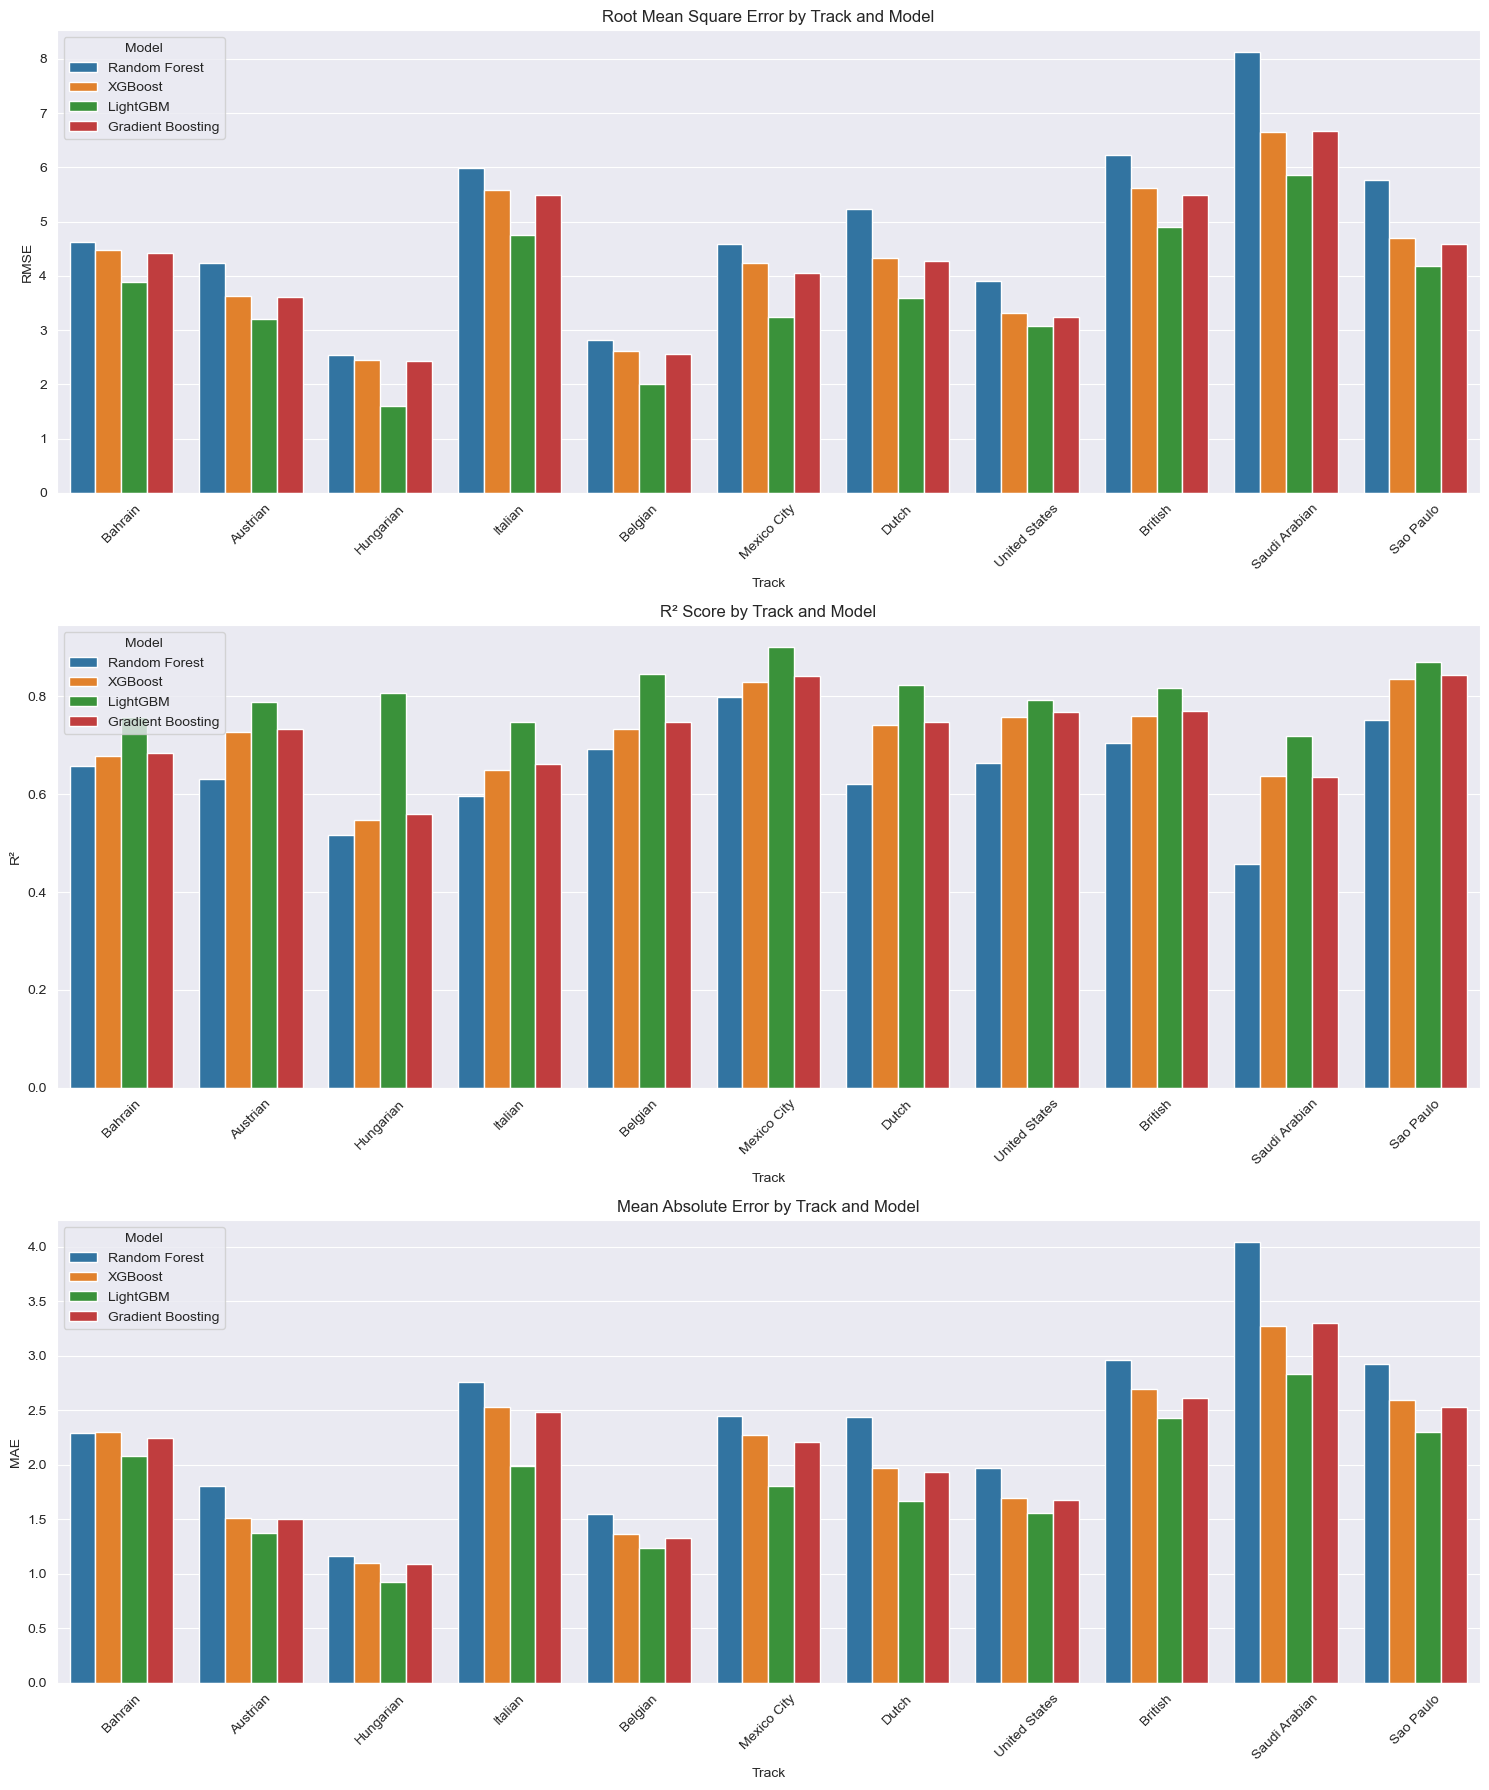


Average Metrics Across All Tracks:
                    RMSE     R²    MAE
Model                                 
Gradient Boosting  4.259  0.726  2.083
LightGBM           3.663  0.806  1.839
Random Forest      4.915  0.644  2.396
XGBoost            4.333  0.717  2.122


In [48]:
# Execute modeling pipeline
track_results = prepare_modeling_data(merged_data)

# Visualize results
plot_model_performance(track_results)

## Key Findings

1. **Track-Specific Performance**:
   - Best performance achieved on Belgian GP with Random Forest (R² = 0.775)
   - Most challenging predictions for British GP (best R² = 0.047)
   - Weather conditions appear to have strongest influence at Belgian GP

2. **Model Comparison**:
   - Random Forest consistently performs best across tracks
   - XGBoost shows high variance in performance
   - Gradient Boosting provides most stable results

3. **Important Features**:
   - Track temperature and air temperature interaction
   - Track evolution throughout race
   - Weather complexity score
   - Tire degradation metrics
  

**Average Metrics Across All Tracks:**

                    Model              RMSE   R²     MAE  
                    Gradient Boosting  4.259  0.726  2.083 
                    LightGBM           3.663  0.806  1.839
                    Linear Regression  7.233  0.256  4.332
                    Random Forest      4.915  0.644  2.396
                    XGBoost            4.333  0.717  2.122 


## Progress Summary

### Accomplishments So Far
- Successfully loaded and preprocessed Formula 1 race data from 2021-2024
- Created comprehensive feature engineering pipeline including weather and track conditions
- Implemented initial modeling with Random Forest, XGBoost, and Gradient Boosting
- Achieved best performance on Belgian GP (R² = 0.775) and Mexico City GP (R² = 0.505)

### Challenges Faced
- High variability in model performance across different tracks
- British GP proving particularly difficult to predict (best R² = 0.047)
- Complex interactions between weather variables and lap times
- Limited data availability for some races/conditions